In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sktime.forecasting.model_selection import temporal_train_test_split

# For-Sale Inventory

In [2]:
#read csv file and transform into Data Frame 
path = "Raw Data/for_sale_inventory_all_home.csv"
data = pd.read_csv(path)
data = pd.DataFrame(data)
data.head()

RegionID  SizeRank                          RegionName RegionType  \
0    102001         0                       United States    Country   
1    394913         1                        New York, NY        Msa   
2    753899         2  Los Angeles-Long Beach-Anaheim, CA        Msa   
3    394463         3                         Chicago, IL        Msa   
4    394514         4               Dallas-Fort Worth, TX        Msa   

  StateName  10/28/2017  11/4/2017  11/11/2017  11/18/2017  11/25/2017  ...  \
0       NaN   1313144.0  1306211.0   1295559.0   1282592.0   1264313.0  ...   
1        NY     67063.0    66557.0     65763.0     64791.0     63528.0  ...   
2        CA     17787.0    17522.0     17177.0     16809.0     16334.0  ...   
3        IL     38027.0    37590.0     36926.0     36131.0     35079.0  ...   
4        TX     21912.0    21836.0     21550.0     21306.0     20883.0  ...   

   8/1/2020  8/8/2020  8/15/2020  8/22/2020  8/29/2020  9/5/2020  9/12/2020  \
0    964279    953389     941273     930423     920394    915373     906542   
1     60547     60457      60445      60285      60329     60543      60632   
2     17224     17225      17197      17140      17079     17120      17105   
3     31418     31315      31087      31004      30933     30905      30862   
4     23510     23106      22714      22296      21915     21631      21214   

   9/19/2020  9/26/2020  10/3/2020  
0     900360     893541     882454  
1      60813      60902      61010  
2      17159      17231      17263  
3      30845      30871      30759  
4      20849      20461      20023  

[5 rows x 159 columns]

# Dallas-Fort Worth, TX - Clean Data

In [3]:
inventory = data[data['RegionName'].isin(['Dallas-Fort Worth, TX'])]
inventory = inventory.drop(columns=['RegionID', 'SizeRank','RegionName','RegionType','StateName'])

In [4]:
inventory = inventory.transpose()
inventory.head()

4
10/28/2017  21912.0
11/4/2017   21836.0
11/11/2017  21550.0
11/18/2017  21306.0
11/25/2017  20883.0

In [5]:
inventory = inventory.reset_index()

In [6]:
inventory = inventory[['index',4]].copy()
inventory.columns =['date','inventory']

In [7]:
inventory.head()

date  inventory
0  10/28/2017    21912.0
1   11/4/2017    21836.0
2  11/11/2017    21550.0
3  11/18/2017    21306.0
4  11/25/2017    20883.0

In [8]:
inventory['date'] = inventory.date.astype('datetime64')
inventory = inventory.set_index('date')
inventory.head()

inventory
date                 
2017-10-28    21912.0
2017-11-04    21836.0
2017-11-11    21550.0
2017-11-18    21306.0
2017-11-25    20883.0

# Split Train/Test Data 

In [9]:
train, test = temporal_train_test_split(inventory)
print(train.shape[0], test.shape[0])
print(train.head())
print(test.head())
combine = pd.concat([train,test])
print(combine.head())

115 39
            inventory
date                 
2017-10-28    21912.0
2017-11-04    21836.0
2017-11-11    21550.0
2017-11-18    21306.0
2017-11-25    20883.0
            inventory
date                 
2020-01-11    23653.0
2020-01-18    23123.0
2020-01-25    23189.0
2020-02-01    23317.0
2020-02-08    23503.0
            inventory
date                 
2017-10-28    21912.0
2017-11-04    21836.0
2017-11-11    21550.0
2017-11-18    21306.0
2017-11-25    20883.0


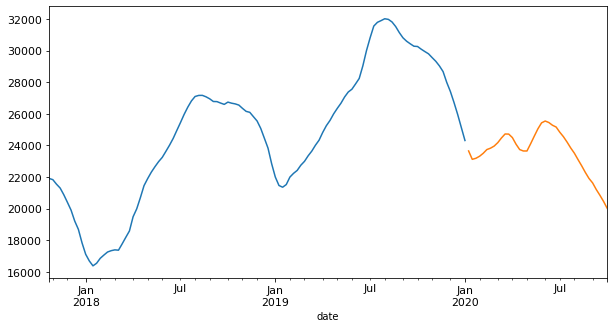

In [10]:
train.inventory.plot(figsize=(10,5), fontsize=11)
test.inventory.plot(figsize=(10,5), fontsize=11)

# Import Machine Learning Models

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA

# ARIMA

In [12]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
arima = ARIMA(train.inventory, order=(0, 1, 1)).fit()
fcst_arima = pd.DataFrame(arima.forecast(39)[0], index=test.index)
test['arima'] = fcst_arima
test.tail()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


inventory         arima
date                               
2020-09-05    21631.0  24731.323620
2020-09-12    21214.0  24750.077470
2020-09-19    20849.0  24768.831319
2020-09-26    20461.0  24787.585169
2020-10-03    20023.0  24806.339019

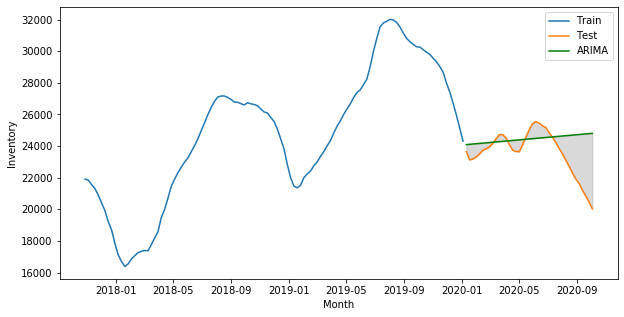

In [13]:
#ARIMA chart
plt.figure(figsize=(10,5))
plt.plot(train['inventory'], label='Train')
plt.plot(test['inventory'], label='Test')
plt.plot(test['arima'], label='ARIMA', color='green')

lower_series = test['inventory']
upper_series = test['arima']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.xlabel('Month')
plt.ylabel('Inventory')
plt.legend(loc='best')
plt.show()

In [14]:
RMSE_arima = sm.tools.eval_measures.rmse(test.inventory,test['arima'])
print('RMSE', '=', RMSE_arima)

RMSE = 1686.7967072786512


# Moving Average

In [15]:
ma = inventory['inventory'].rolling(2).mean().shift()
fcst_ma = ma.loc[test.index]
test['ma'] = fcst_ma
test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


inventory         arima       ma
date                                        
2020-01-11    23653.0  24093.692726  24725.5
2020-01-18    23123.0  24112.446576  23983.5
2020-01-25    23189.0  24131.200426  23388.0
2020-02-01    23317.0  24149.954276  23156.0
2020-02-08    23503.0  24168.708126  23253.0

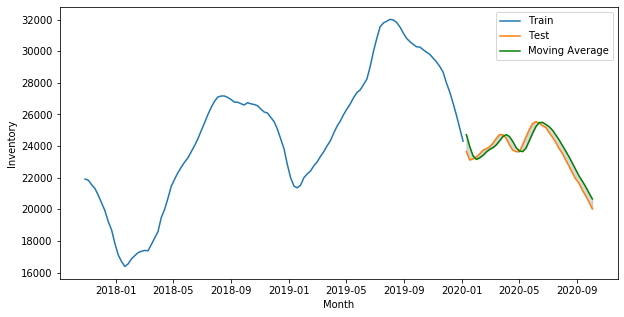

In [16]:
#Moving Average chart
plt.figure(figsize=(10,5))
plt.plot(train['inventory'], label='Train')
plt.plot(test['inventory'], label='Test')
plt.plot(test['ma'], label='Moving Average', color='green')

lower_series = test['inventory']
upper_series = test['ma']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.xlabel('Month')
plt.ylabel('Inventory')
plt.legend(loc='best')
plt.show()

In [17]:
RMSE_ma = sm.tools.eval_measures.rmse(test.inventory,test['ma'])
print('RMSE', '=', RMSE_ma)

RMSE = 486.1904897339029


# Naive

In [18]:
#Naive (using SES with alpha=1)
naive = SimpleExpSmoothing(train.inventory).fit(smoothing_level=1, optimized=False)
fcst_naive = SimpleExpSmoothing(combine.inventory).fit(smoothing_level=1, optimized=False)
test['naive'] = fcst_naive.fittedvalues.loc[test.index]
test.tail()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


inventory         arima       ma    naive
date                                                 
2020-09-05    21631.0  24731.323620  22105.5  21915.0
2020-09-12    21214.0  24750.077470  21773.0  21631.0
2020-09-19    20849.0  24768.831319  21422.5  21214.0
2020-09-26    20461.0  24787.585169  21031.5  20849.0
2020-10-03    20023.0  24806.339019  20655.0  20461.0

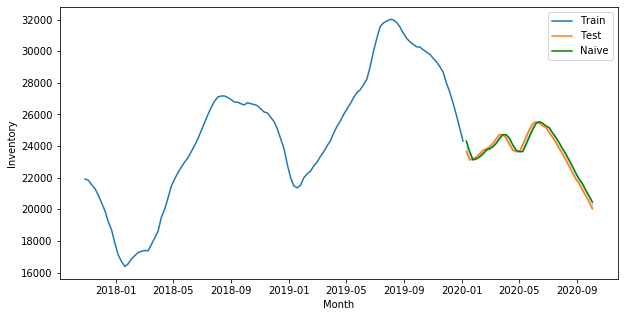

In [19]:
#Naive chart
plt.figure(figsize=(10,5))
plt.plot(train['inventory'], label='Train')
plt.plot(test['inventory'], label='Test')
plt.plot(test['naive'], label='Naive', color='green')

lower_series = test['inventory']
upper_series = test['naive']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Inventory')
plt.xlabel('Month')
plt.legend(loc='best')
plt.show()

In [20]:
RMSE_naive = sm.tools.eval_measures.rmse(test.inventory,test['naive'])
print('RMSE', '=', RMSE_naive)

RMSE = 327.46786884854083


# Simple Exponenital Smoothing 

In [21]:
#Simple Exponenital Smoothing
ses = SimpleExpSmoothing(train.inventory).fit()
fcst_ses = SimpleExpSmoothing(test.inventory).fit(smoothing_level=ses.model.params['smoothing_level'], optimized=False)
test['ses'] = fcst_ses.fittedvalues
test.head()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after 

inventory         arima       ma    naive      ses
date                                                          
2020-01-11    23653.0  24093.692726  24725.5  24314.0  23653.0
2020-01-18    23123.0  24112.446576  23983.5  23653.0  23653.0
2020-01-25    23189.0  24131.200426  23388.0  23123.0  23123.0
2020-02-01    23317.0  24149.954276  23156.0  23189.0  23189.0
2020-02-08    23503.0  24168.708126  23253.0  23317.0  23317.0

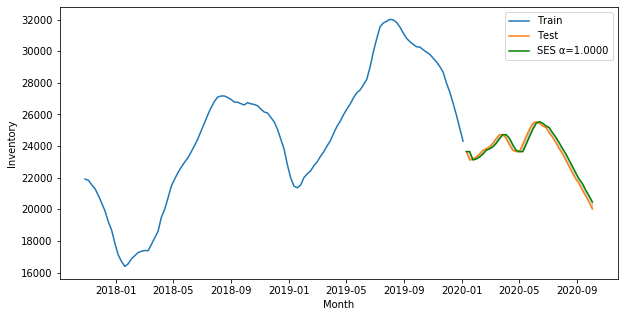

In [22]:
#Simple Exponenital Smoothing chart
plt.figure(figsize=(10,5))
plt.plot(train['inventory'], label='Train')
plt.plot(test['inventory'], label='Test')
plt.plot(test['ses'], label='SES \u03B1='+ "{:.4f}".format(ses.model.params['smoothing_level']), color='green')

lower_series = test['inventory']
upper_series = test['ses']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Inventory')
plt.xlabel('Month')
plt.legend(loc='best')
plt.show()

In [23]:
RMSE_ses = sm.tools.eval_measures.rmse(test.inventory,test['ses'])
print('RMSE', '=', RMSE_ses)

RMSE = 309.8904686564312


# Holt Winter (Additive)

In [24]:
#Holt Winter (t = 3 months, additive)
holtwinter_add = ExponentialSmoothing(train.inventory, seasonal_periods=12, trend='add', seasonal='add').fit()
fcst_holtwinter_add = ExponentialSmoothing(test.inventory, seasonal_periods=12, trend='add', seasonal='add').fit(smoothing_level=holtwinter_add.model.params['smoothing_level'], smoothing_slope=holtwinter_add.model.params['smoothing_slope'], smoothing_seasonal=holtwinter_add.model.params['smoothing_seasonal'], optimized=False)
test['holtwinter_add'] = fcst_holtwinter_add.fittedvalues
test.head()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq

inventory         arima       ma    naive      ses  holtwinter_add
date                                                                          
2020-01-11    23653.0  24093.692726  24725.5  24314.0  23653.0    23713.138889
2020-01-18    23123.0  24112.446576  23983.5  23653.0  23653.0    23209.959834
2020-01-25    23189.0  24131.200426  23388.0  23123.0  23123.0    23286.255632
2020-02-01    23317.0  24149.954276  23156.0  23189.0  23189.0    23416.438528
2020-02-08    23503.0  24168.708126  23253.0  23317.0  23317.0    23600.718001

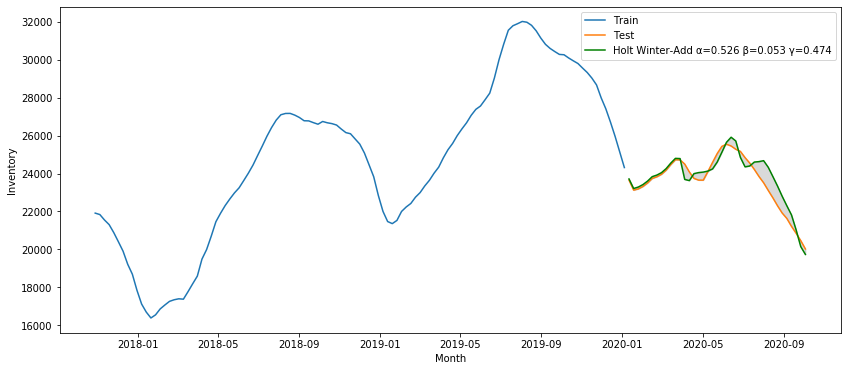

In [25]:
#Holt Winter (Additive) chart
plt.figure(figsize=(14,6))
plt.plot(train['inventory'], label='Train')
plt.plot(test['inventory'], label='Test')
plt.plot(test['holtwinter_add'], label='Holt Winter-Add \u03B1='+"{:.3f}".format(holtwinter_add.model.params['smoothing_level'])+' \u03B2='+"{:.3f}".format(holtwinter_add.model.params['smoothing_slope'])+' \u03B3='+"{:.3f}".format(holtwinter_add.model.params['smoothing_seasonal']), color='green')

lower_series = test['inventory']
upper_series = test['holtwinter_add']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Inventory')
plt.xlabel('Month')
plt.legend(loc='best')
plt.show()

In [26]:
RMSE_holtwinter_add = sm.tools.eval_measures.rmse(test.inventory,test['holtwinter_add'])
print('RMSE', '=', RMSE_holtwinter_add)

RMSE = 514.4831794724482


# Forecast

In [27]:
fcst_inventory = ses.predict(start= len(train), 
                          end = (len(train)-3) + 5 * 12).rename('forecast')
fcst_inventory.tail()

2021-01-16    24314.0
2021-01-23    24314.0
2021-01-30    24314.0
2021-02-06    24314.0
2021-02-13    24314.0
Freq: W-SAT, Name: forecast, dtype: float64

In [28]:
fcst_inventory = fcst_inventory.loc['20201010':'20210213']
fcst_inventory = pd.DataFrame(fcst_inventory)
fcst_inventory.head()

forecast
2020-10-10   24314.0
2020-10-17   24314.0
2020-10-24   24314.0
2020-10-31   24314.0
2020-11-07   24314.0

In [29]:
fcst_inventory = fcst_inventory.reset_index()

In [30]:
fcst_inventory.columns =['date','forecast']
fcst_inventory.head()

date  forecast
0 2020-10-10   24314.0
1 2020-10-17   24314.0
2 2020-10-24   24314.0
3 2020-10-31   24314.0
4 2020-11-07   24314.0

In [31]:
fcst_inventory = fcst_inventory.set_index('date')
fcst_inventory.head()

forecast
date                
2020-10-10   24314.0
2020-10-17   24314.0
2020-10-24   24314.0
2020-10-31   24314.0
2020-11-07   24314.0

# Merge Test Data/Forecast

In [32]:
test = test.merge(fcst_inventory, how='outer', on='date')
test.tail()

inventory  arima  ma  naive  ses  holtwinter_add  forecast
date                                                                  
2021-01-16        NaN    NaN NaN    NaN  NaN             NaN   24314.0
2021-01-23        NaN    NaN NaN    NaN  NaN             NaN   24314.0
2021-01-30        NaN    NaN NaN    NaN  NaN             NaN   24314.0
2021-02-06        NaN    NaN NaN    NaN  NaN             NaN   24314.0
2021-02-13        NaN    NaN NaN    NaN  NaN             NaN   24314.0

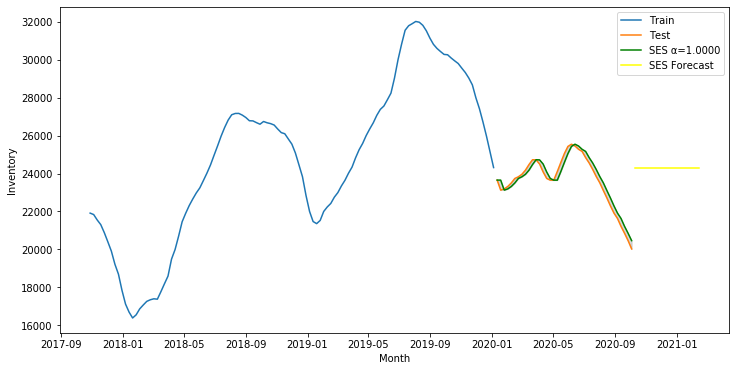

In [33]:
#Updated SES chart 
plt.figure(figsize=(12,6))
plt.plot(train['inventory'], label='Train')
plt.plot(test['inventory'], label='Test')
plt.plot(test['ses'], label='SES \u03B1='+ "{:.4f}".format(ses.model.params['smoothing_level']), color='green')
plt.plot(test['forecast'], label='SES Forecast', color='yellow')

lower_series = test['inventory']
upper_series = test['ses']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Inventory')
plt.xlabel('Month')
plt.legend(loc='best')
plt.show()

# Summary/Inventory Output

In [34]:
test.head()

inventory         arima       ma    naive      ses  \
date                                                             
2020-01-11    23653.0  24093.692726  24725.5  24314.0  23653.0   
2020-01-18    23123.0  24112.446576  23983.5  23653.0  23653.0   
2020-01-25    23189.0  24131.200426  23388.0  23123.0  23123.0   
2020-02-01    23317.0  24149.954276  23156.0  23189.0  23189.0   
2020-02-08    23503.0  24168.708126  23253.0  23317.0  23317.0   

            holtwinter_add  forecast  
date                                  
2020-01-11    23713.138889       NaN  
2020-01-18    23209.959834       NaN  
2020-01-25    23286.255632       NaN  
2020-02-01    23416.438528       NaN  
2020-02-08    23600.718001       NaN

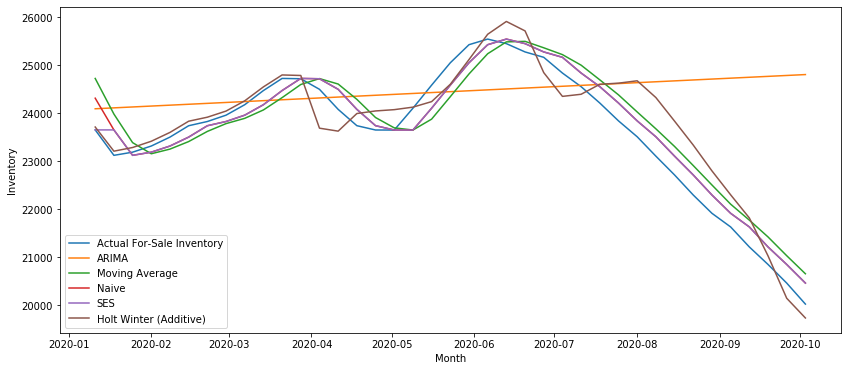

In [35]:
plt.figure(figsize=(14,6))
plt.plot(test['inventory'], label='Actual For-Sale Inventory')
plt.plot(test['arima'], label='ARIMA')
plt.plot(test['ma'] , label='Moving Average')
plt.plot(test['naive'] , label='Naive')
plt.plot(test['ses'] , label='SES')
plt.plot(test['holtwinter_add'] , label='Holt Winter (Additive)')

plt.ylabel('Inventory')
plt.xlabel('Month')
plt.legend(loc='best')
plt.show()

In [36]:
RMSE = pd.DataFrame({'Model':['ARIMA', 'Moving Average', 'Naive','Simple Exponential Smoothing','Holt Winter (Additive)'],
                     'RMSE':[RMSE_arima, RMSE_ma, RMSE_naive, RMSE_ses, RMSE_holtwinter_add]})
RMSE

Model         RMSE
0                         ARIMA  1686.796707
1                Moving Average   486.190490
2                         Naive   327.467869
3  Simple Exponential Smoothing   309.890469
4        Holt Winter (Additive)   514.483179

# We choose to use "Simple Exponential Smoothing" method to predict future For-Sale Inventory

In [37]:
final_fcst_inventory = test[['ses','forecast']].copy()
final_fcst_inventory.head()

ses  forecast
date                         
2020-01-11  23653.0       NaN
2020-01-18  23653.0       NaN
2020-01-25  23123.0       NaN
2020-02-01  23189.0       NaN
2020-02-08  23317.0       NaN

In [38]:
final_output_inventory = combine.merge(final_fcst_inventory, how='outer', on='date')
final_output_inventory = final_output_inventory.rename(columns={"ses": "ses_inventory", "forecast": "fcst_inventory"})
final_output_inventory.head()

inventory  ses_inventory  fcst_inventory
date                                                
2017-10-28    21912.0            NaN             NaN
2017-11-04    21836.0            NaN             NaN
2017-11-11    21550.0            NaN             NaN
2017-11-18    21306.0            NaN             NaN
2017-11-25    20883.0            NaN             NaN

# Median Sale Price 

In [39]:
#read csv file and transform into Data Frame 
path = "Raw Data/median_price_all_home.csv"
data = pd.read_csv(path)
data = pd.DataFrame(data)
data.head()

RegionID  SizeRank                          RegionName RegionType  \
0    102001         0                       United States    Country   
1    394913         1                        New York, NY        Msa   
2    753899         2  Los Angeles-Long Beach-Anaheim, CA        Msa   
3    394463         3                         Chicago, IL        Msa   
4    394514         4               Dallas-Fort Worth, TX        Msa   

  StateName  2/23/2008  3/1/2008  3/8/2008  3/15/2008  3/22/2008  ...  \
0       NaN   202677.0  202747.0  202257.0   201873.0   201850.0  ...   
1        NY        NaN       NaN       NaN        NaN        NaN  ...   
2        CA   514232.0  510894.0  507034.0   506298.0   502279.0  ...   
3        IL   259849.0  260755.0  258484.0   257759.0   254957.0  ...   
4        TX   154425.0  152707.0  152883.0   152609.0   153028.0  ...   

   6/20/2020  6/27/2020  7/4/2020  7/11/2020  7/18/2020  7/25/2020  8/1/2020  \
0     267037     267673    269670     271861     273466     275489    275932   
1     434040     432603    433680     431969     433146     432294    433968   
2     679775     679951    685348     688100     690707     694605    695155   
3     245654     246339    246702     248206     249497     249427    250909   
4     280250     282081    283878     285911     286132     287928    288888   

   8/8/2020  8/15/2020  8/22/2020  
0  277047.0   277801.0   278595.0  
1  437629.0   440015.0   441896.0  
2  698233.0   704817.0   706541.0  
3  253268.0   254976.0   257348.0  
4  290070.0   291165.0   291204.0  

[5 rows x 658 columns]

# Dallas-Fort Worth, TX - Clean Data

In [40]:
price = data[data['RegionName'].isin(['Dallas-Fort Worth, TX'])]
price = price.drop(columns=['RegionID', 'SizeRank','RegionName','RegionType','StateName'])

In [41]:
price = price.transpose()
price.head()

4
2/23/2008  154425.0
3/1/2008   152707.0
3/8/2008   152883.0
3/15/2008  152609.0
3/22/2008  153028.0

In [42]:
price = price.reset_index()

In [43]:
price = price[['index',4]].copy()
price.columns =['date','price']

In [44]:
price.head()

date     price
0  2/23/2008  154425.0
1   3/1/2008  152707.0
2   3/8/2008  152883.0
3  3/15/2008  152609.0
4  3/22/2008  153028.0

In [45]:
price['date'] = price.date.astype('datetime64')
price = price.set_index('date')
price.head()

price
date                
2008-02-23  154425.0
2008-03-01  152707.0
2008-03-08  152883.0
2008-03-15  152609.0
2008-03-22  153028.0

In [46]:
price = price.dropna()
price.head()

price
date                
2008-02-23  154425.0
2008-03-01  152707.0
2008-03-08  152883.0
2008-03-15  152609.0
2008-03-22  153028.0

# Split Train/Test Data

In [47]:
train, test = temporal_train_test_split(price)
print(train.shape[0], test.shape[0])
print(train.head())
print(test.head())
combine = pd.concat([train,test])
print(combine.head())

489 164
               price
date                
2008-02-23  154425.0
2008-03-01  152707.0
2008-03-08  152883.0
2008-03-15  152609.0
2008-03-22  153028.0
               price
date                
2017-07-08  248345.0
2017-07-15  249787.0
2017-07-22  249265.0
2017-07-29  250791.0
2017-08-05  251525.0
               price
date                
2008-02-23  154425.0
2008-03-01  152707.0
2008-03-08  152883.0
2008-03-15  152609.0
2008-03-22  153028.0


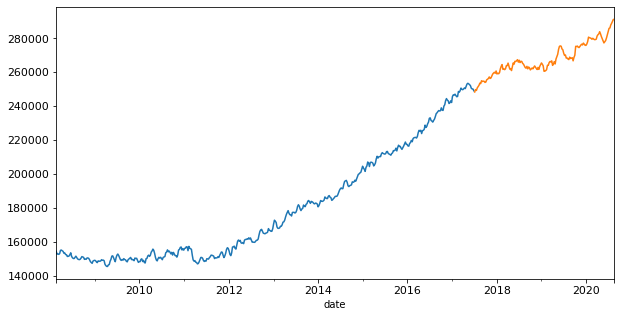

In [48]:
train.price.plot(figsize=(10,5), fontsize=11)
test.price.plot(figsize=(10,5), fontsize=11)

# ARIMA

In [49]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
arima = ARIMA(train.price, order=(0, 1, 1)).fit()
fcst_arima = pd.DataFrame(arima.forecast(164)[0], index=test.index)
test['arima'] = fcst_arima
test.tail()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


price          arima
date                               
2020-07-25  287928.0  279619.593768
2020-08-01  288888.0  279812.042760
2020-08-08  290070.0  280004.491751
2020-08-15  291165.0  280196.940743
2020-08-22  291204.0  280389.389734

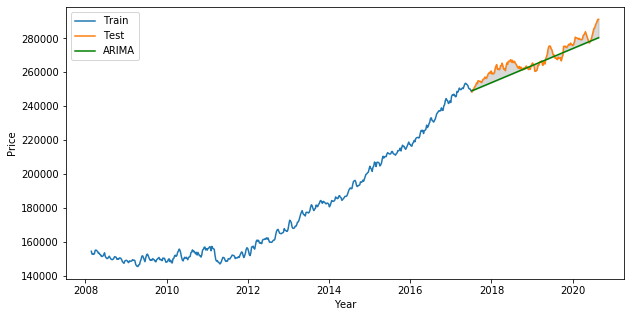

In [50]:
#ARIMA chart
plt.figure(figsize=(10,5))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(test['arima'], label='ARIMA', color='green')

lower_series = test['price']
upper_series = test['arima']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [51]:
RMSE_arima = sm.tools.eval_measures.rmse(test.price,test['arima'])
print('RMSE', '=', RMSE_arima)

RMSE = 4623.577908754519


# Moving Average

In [52]:
ma = price['price'].rolling(5).mean().shift()
fcst_ma = ma.loc[test.index]
test['ma'] = fcst_ma
test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


price          arima        ma
date                                         
2017-07-08  248345.0  249020.204119  250413.4
2017-07-15  249787.0  249212.653110  249660.0
2017-07-22  249265.0  249405.102102  249495.2
2017-07-29  250791.0  249597.551093  249315.2
2017-08-05  251525.0  249790.000085  249450.8

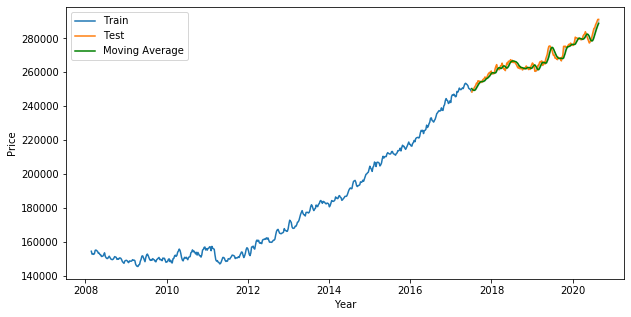

In [53]:
#Moving Average chart
plt.figure(figsize=(10,5))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(test['ma'], label='Moving Average', color='green')

lower_series = test['price']
upper_series = test['ma']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [54]:
RMSE_ma = sm.tools.eval_measures.rmse(test.price,test['ma'])
print('RMSE', '=', RMSE_ma)

RMSE = 2224.6929108443187


# Naive

In [55]:
#Naive (using SES with alpha=1)
naive = SimpleExpSmoothing(train.price).fit(smoothing_level=1, optimized=False)
fcst_naive = SimpleExpSmoothing(combine.price).fit(smoothing_level=1, optimized=False)
test['naive'] = fcst_naive.fittedvalues.loc[test.index]
test.tail()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


price          arima        ma     naive
date                                                   
2020-07-25  287928.0  279619.593768  283650.4  286132.0
2020-08-01  288888.0  279812.042760  285186.0  287928.0
2020-08-08  290070.0  280004.491751  286547.4  288888.0
2020-08-15  291165.0  280196.940743  287785.8  290070.0
2020-08-22  291204.0  280389.389734  288836.6  291165.0

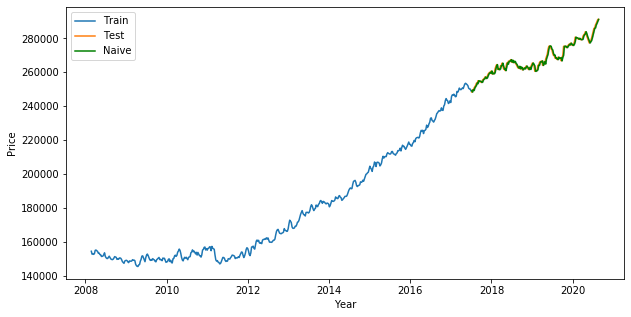

In [56]:
#Naive chart
plt.figure(figsize=(10,5))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(test['naive'], label='Naive', color='green')

lower_series = test['price']
upper_series = test['naive']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Price')
plt.xlabel('Year')
plt.legend(loc='best')
plt.show()

In [57]:
RMSE_naive = sm.tools.eval_measures.rmse(test.price,test['naive'])
print('RMSE', '=', RMSE_naive)

RMSE = 1253.7615014184414


# Simple Exponenital Smoothing 

In [58]:
#Simple Exponenital Smoothing
ses = SimpleExpSmoothing(train.price).fit()
fcst_ses = SimpleExpSmoothing(test.price).fit(smoothing_level=ses.model.params['smoothing_level'], optimized=False)
test['ses'] = fcst_ses.fittedvalues
test.head()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after 

price          arima        ma     naive       ses
date                                                             
2017-07-08  248345.0  249020.204119  250413.4  249066.0  248345.0
2017-07-15  249787.0  249212.653110  249660.0  248345.0  248345.0
2017-07-22  249265.0  249405.102102  249495.2  249787.0  249787.0
2017-07-29  250791.0  249597.551093  249315.2  249265.0  249265.0
2017-08-05  251525.0  249790.000085  249450.8  250791.0  250791.0

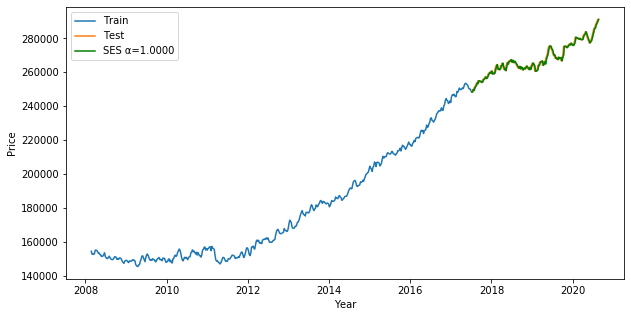

In [59]:
#Simple Exponenital Smoothing chart
plt.figure(figsize=(10,5))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(test['ses'], label='SES \u03B1='+ "{:.4f}".format(ses.model.params['smoothing_level']), color='green')

lower_series = test['price']
upper_series = test['ses']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Price')
plt.xlabel('Year')
plt.legend(loc='best')
plt.show()

In [60]:
RMSE_ses = sm.tools.eval_measures.rmse(test.price,test['ses'])
print('RMSE', '=', RMSE_ses)

RMSE = 1252.496762568232


# Holt Winter (Additive)

In [61]:
#Holt Winter (t = 3 months, additive)
holtwinter_add = ExponentialSmoothing(train.price, seasonal_periods=12, trend='add', seasonal='add').fit()
fcst_holtwinter_add = ExponentialSmoothing(test.price, seasonal_periods=12, trend='add', seasonal='add').fit(smoothing_level=holtwinter_add.model.params['smoothing_level'], smoothing_slope=holtwinter_add.model.params['smoothing_slope'], smoothing_seasonal=holtwinter_add.model.params['smoothing_seasonal'], optimized=False)
test['holtwinter_add'] = fcst_holtwinter_add.fittedvalues
test.tail()

C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\emmayianpan\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

price          arima        ma     naive       ses  \
date                                                                
2020-07-25  287928.0  279619.593768  283650.4  286132.0  286132.0   
2020-08-01  288888.0  279812.042760  285186.0  287928.0  287928.0   
2020-08-08  290070.0  280004.491751  286547.4  288888.0  288888.0   
2020-08-15  291165.0  280196.940743  287785.8  290070.0  290070.0   
2020-08-22  291204.0  280389.389734  288836.6  291165.0  291165.0   

            holtwinter_add  
date                        
2020-07-25   286093.185660  
2020-08-01   288466.551094  
2020-08-08   289885.976053  
2020-08-15   291703.884747  
2020-08-22   292262.293565

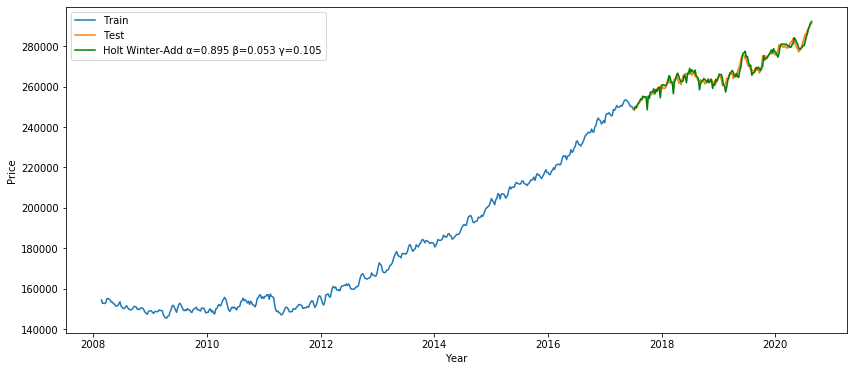

In [62]:
#Holt Winter (Additive) chart
plt.figure(figsize=(14,6))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(test['holtwinter_add'], label='Holt Winter-Add \u03B1='+"{:.3f}".format(holtwinter_add.model.params['smoothing_level'])+' \u03B2='+"{:.3f}".format(holtwinter_add.model.params['smoothing_slope'])+' \u03B3='+"{:.3f}".format(holtwinter_add.model.params['smoothing_seasonal']), color='green')

lower_series = test['price']
upper_series = test['holtwinter_add']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Price')
plt.xlabel('Year')
plt.legend(loc='best')
plt.show()

In [63]:
RMSE_holtwinter_add = sm.tools.eval_measures.rmse(test.price,test['holtwinter_add'])
print('RMSE', '=', RMSE_holtwinter_add)

RMSE = 1955.8607198270593


# Forecast

In [64]:
fcst_price = ses.predict(start= len(train), 
                          end = (len(train)-3) + 17 * 12).rename('forecast')
fcst_price.tail(40)

2020-08-15    249066.0
2020-08-22    249066.0
2020-08-29    249066.0
2020-09-05    249066.0
2020-09-12    249066.0
2020-09-19    249066.0
2020-09-26    249066.0
2020-10-03    249066.0
2020-10-10    249066.0
2020-10-17    249066.0
2020-10-24    249066.0
2020-10-31    249066.0
2020-11-07    249066.0
2020-11-14    249066.0
2020-11-21    249066.0
2020-11-28    249066.0
2020-12-05    249066.0
2020-12-12    249066.0
2020-12-19    249066.0
2020-12-26    249066.0
2021-01-02    249066.0
2021-01-09    249066.0
2021-01-16    249066.0
2021-01-23    249066.0
2021-01-30    249066.0
2021-02-06    249066.0
2021-02-13    249066.0
2021-02-20    249066.0
2021-02-27    249066.0
2021-03-06    249066.0
2021-03-13    249066.0
2021-03-20    249066.0
2021-03-27    249066.0
2021-04-03    249066.0
2021-04-10    249066.0
2021-04-17    249066.0
2021-04-24    249066.0
2021-05-01    249066.0
2021-05-08    249066.0
2021-05-15    249066.0
Freq: W-SAT, Name: forecast, dtype: float64

In [65]:
fcst_price = fcst_price.loc['20200829':'20210515']
fcst_price = pd.DataFrame(fcst_price)
fcst_price.head()

forecast
2020-08-29  249066.0
2020-09-05  249066.0
2020-09-12  249066.0
2020-09-19  249066.0
2020-09-26  249066.0

In [66]:
fcst_price = fcst_price.reset_index()

In [67]:
fcst_price.columns =['date','forecast']
fcst_price.head()

date  forecast
0 2020-08-29  249066.0
1 2020-09-05  249066.0
2 2020-09-12  249066.0
3 2020-09-19  249066.0
4 2020-09-26  249066.0

In [68]:
fcst_price = fcst_price.set_index('date')
fcst_price.head()

forecast
date                
2020-08-29  249066.0
2020-09-05  249066.0
2020-09-12  249066.0
2020-09-19  249066.0
2020-09-26  249066.0

# Merge Test Data/Forecast

In [69]:
test = test.merge(fcst_price, how='outer', on='date')
test.tail()

price  arima  ma  naive  ses  holtwinter_add  forecast
date                                                              
2021-04-17    NaN    NaN NaN    NaN  NaN             NaN  249066.0
2021-04-24    NaN    NaN NaN    NaN  NaN             NaN  249066.0
2021-05-01    NaN    NaN NaN    NaN  NaN             NaN  249066.0
2021-05-08    NaN    NaN NaN    NaN  NaN             NaN  249066.0
2021-05-15    NaN    NaN NaN    NaN  NaN             NaN  249066.0

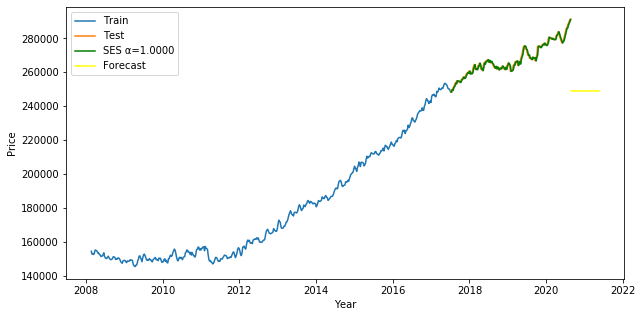

In [70]:
#Simple Exponenital Smoothing chart
plt.figure(figsize=(10,5))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(test['ses'], label='SES \u03B1='+ "{:.4f}".format(ses.model.params['smoothing_level']), color='green')
plt.plot(test['forecast'], label='Forecast', color='yellow')

lower_series = test['price']
upper_series = test['ses']

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.ylabel('Price')
plt.xlabel('Year')
plt.legend(loc='best')
plt.show()

# Summary/Inventory Output

In [71]:
test.head()

price          arima        ma     naive       ses  \
date                                                                
2017-07-08  248345.0  249020.204119  250413.4  249066.0  248345.0   
2017-07-15  249787.0  249212.653110  249660.0  248345.0  248345.0   
2017-07-22  249265.0  249405.102102  249495.2  249787.0  249787.0   
2017-07-29  250791.0  249597.551093  249315.2  249265.0  249265.0   
2017-08-05  251525.0  249790.000085  249450.8  250791.0  250791.0   

            holtwinter_add  forecast  
date                                  
2017-07-08   248723.861111       NaN  
2017-07-15   250187.899989       NaN  
2017-07-22   249649.341004       NaN  
2017-07-29   251155.498890       NaN  
2017-08-05   251870.245575       NaN

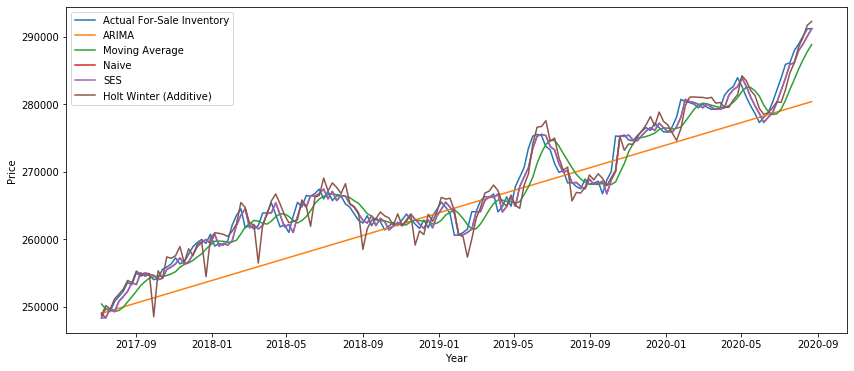

In [72]:
plt.figure(figsize=(14,6))
plt.plot(test['price'], label='Actual For-Sale Inventory')
plt.plot(test['arima'], label='ARIMA')
plt.plot(test['ma'] , label='Moving Average')
plt.plot(test['naive'] , label='Naive')
plt.plot(test['ses'] , label='SES')
plt.plot(test['holtwinter_add'] , label='Holt Winter (Additive)')

plt.ylabel('Price')
plt.xlabel('Year')
plt.legend(loc='best')
plt.show()

In [73]:
RMSE = pd.DataFrame({'Model':['ARIMA', 'Moving Average', 'Naive','Simple Exponential Smoothing','Holt Winter (Additive)'],
                     'RMSE':[RMSE_arima, RMSE_ma, RMSE_naive, RMSE_ses, RMSE_holtwinter_add]})
RMSE

Model         RMSE
0                         ARIMA  4623.577909
1                Moving Average  2224.692911
2                         Naive  1253.761501
3  Simple Exponential Smoothing  1252.496763
4        Holt Winter (Additive)  1955.860720

# We choose to use "Simple Exponenital Smoothing" method to predict future Median Sale Price

In [74]:
final_fcst_price = test[['ses','forecast']].copy()
final_fcst_price.head()

ses  forecast
date                          
2017-07-08  248345.0       NaN
2017-07-15  248345.0       NaN
2017-07-22  249787.0       NaN
2017-07-29  249265.0       NaN
2017-08-05  250791.0       NaN

In [75]:
final_output_price = combine.merge(final_fcst_price, how='outer', on='date')
final_output_price = final_output_price.rename(columns={"ses": "ses_price", "forecast": "fcst_price"})
final_output_price.head()

price  ses_price  fcst_price
date                                       
2008-02-23  154425.0        NaN         NaN
2008-03-01  152707.0        NaN         NaN
2008-03-08  152883.0        NaN         NaN
2008-03-15  152609.0        NaN         NaN
2008-03-22  153028.0        NaN         NaN

In [76]:
final_output = final_output_inventory.merge(final_output_price, how='outer', on='date')
final_output.head()

inventory  ses_inventory  fcst_inventory     price  ses_price  \
date                                                                        
2017-10-28    21912.0            NaN             NaN  256344.0   255896.0   
2017-11-04    21836.0            NaN             NaN  257251.0   256344.0   
2017-11-11    21550.0            NaN             NaN  256349.0   257251.0   
2017-11-18    21306.0            NaN             NaN  256639.0   256349.0   
2017-11-25    20883.0            NaN             NaN  257782.0   256639.0   

            fcst_price  
date                    
2017-10-28         NaN  
2017-11-04         NaN  
2017-11-11         NaN  
2017-11-18         NaN  
2017-11-25         NaN

In [77]:
final_output.to_csv(r'static\data\dtx.csv', index = True)